# LOVE IS ALL YOU COUNT
##### - by Amanda Seagle and Lorenza Culotta - 

# 1.1. LastFM API calls to get top love songs

In [1]:
#Dependencies
import pandas as pd
import requests
import json
from pprint import pprint
from config import lastfm_api

In [2]:
#Set the parameters to LastFM API calls. Method and Limit are empty so we can adjust them to specific calls\
#like get_top_tracks or track.getInfo

params={
    "tag": "love",
    "api_key": lastfm_api,
    "format": "json",
    "method":"tag.gettoptracks",
    "limit": 2000
}

base_url= "http://ws.audioscrobbler.com/2.0/?"
example_url= "/2.0/?method=tag.gettoptracks&tag=disco&api_key=YOUR_API_KEY&format=json"    #taken from website

#API call for first 1000 songs using tag.getTopTracks
# params["page"]=1

response=requests.get(base_url, params=params).json()
# pprint(response)

results_df=pd.DataFrame(response["tracks"]["track"])
results_df.head()

,name,duration,mbid,url,streamable,artist,image,@attr
0,Wonderwall,259,31623cce-9717-4513-9d83-1b5d04e44f9b,https://www.last.fm/music/Oasis/_/Wonderwall,"{'#text': '0', 'fulltrack': '0'}","{'name': 'Oasis', 'mbid': 'ecf9f3a3-35e9-4c58-...",[{'#text': 'https://lastfm.freetls.fastly.net/...,{'rank': '1'}
1,The Scientist,309,13f5488d-8e41-42d8-9fe9-a5295f1a9a3d,https://www.last.fm/music/Coldplay/_/The+Scien...,"{'#text': '0', 'fulltrack': '0'}","{'name': 'Coldplay', 'mbid': 'cc197bad-dc9c-44...",[{'#text': 'https://lastfm.freetls.fastly.net/...,{'rank': '2'}
2,Yellow,267,8b5bf478-22f8-4902-a1c1-0db82261db58,https://www.last.fm/music/Coldplay/_/Yellow,"{'#text': '0', 'fulltrack': '0'}","{'name': 'Coldplay', 'mbid': 'cc197bad-dc9c-44...",[{'#text': 'https://lastfm.freetls.fastly.net/...,{'rank': '3'}
3,Fix You,294,3af0af54-9c93-4578-9128-d04054286ba3,https://www.last.fm/music/Coldplay/_/Fix+You,"{'#text': '0', 'fulltrack': '0'}","{'name': 'Coldplay', 'mbid': 'cc197bad-dc9c-44...",[{'#text': 'https://lastfm.freetls.fastly.net/...,{'rank': '4'}
4,Chasing Cars,0,f62a3798-6559-4f9b-8b80-6ea3e4ad89aa,https://www.last.fm/music/Snow+Patrol/_/Chasin...,"{'#text': '0', 'fulltrack': '0'}","{'name': 'Snow Patrol', 'mbid': 'a66999a7-ae5c...",[{'#text': 'https://lastfm.freetls.fastly.net/...,{'rank': '5'}


In [3]:
#Create Top Love Songs DataFrame to populate with info retrieved from LastFM
top2000_lovesongs_df=pd.DataFrame({
    "Rank": [],
    "Song Name": [],
    "Artist": [],
    "Album": []
})


In [5]:
#The 2000 songs are in a list under "response["tracks"]["track"]"
results=response["tracks"]["track"]

for index, row in results_df.iterrows():
    song= results[index]["name"]     
    artist= results[index]["artist"]["name"]
#     print(f'Info retrieved for index: {index}')
    
    #Retrieve info about date release of album and track duration
    try:
        song_url=f'http://ws.audioscrobbler.com/2.0/?method=track.getInfo&api_key={lastfm_api}\
                    &track={song}&artist={artist}&format=json'
        song_response=requests.get(song_url).json()
#         print(f'-->Retrieving album name for {song} by {artist}')
        album=song_response["track"]["album"]["title"]

    except (KeyError, IndexError, ValueError):
        print(f'----Missing field/result for {album} by {artist}. Skipping----')
    
    #Populate df
    try:
        top2000_lovesongs_df.loc[index, "Rank"]=results[index]["@attr"]["rank"]
        top2000_lovesongs_df.loc[index, "Song Name"]=results[index]["name"]
        top2000_lovesongs_df.loc[index, "Artist"]=results[index]["artist"]["name"]
        top2000_lovesongs_df.loc[index, "Album"]=song_response["track"]["album"]["title"]
            
    except (KeyError, IndexError):
        print(f'----Missing field/result for {song} by {artist}. Skipping----')

print("-- Fin --")

----Missing field/result for So Far Gone by blink-182. Skipping----
----Missing field/result for I MISS YOU by blink-182. Skipping----
----Missing field/result for Achtung Baby by Edward Sharpe & The Magnetic Zeros. Skipping----
----Missing field/result for Home by Edward Sharpe & The Magnetic Zeros. Skipping----
-- Fin --


In [6]:
#Display dataframe and save as csv to avoid re-running the kernel with API calls
top2000_lovesongs_df.to_csv("Results/csv/top2000_lovesongs_df.csv")
top2000_lovesongs_df.head()

,Rank,Song Name,Artist,Album
0,1,Wonderwall,Oasis,(What's the Story) Morning Glory?
1,2,The Scientist,Coldplay,A Rush of Blood to the Head
2,3,Yellow,Coldplay,Parachutes
3,4,Fix You,Coldplay,X&Y
4,5,Chasing Cars,Snow Patrol,Eyes Open


# 1.2. Retrieve release date and lyrics from Genius
* Find instructions here https://github.com/johnwmillr/LyricsGenius/blob/master/README.md

In [7]:
# #Install lyrics genius module
# !pip install lyricsgenius

In [8]:
#Import lyricsgenius module and config with token
import lyricsgenius
from config import genius_token
genius = lyricsgenius.Genius(genius_token)

In [13]:
#Open top_love_songs csv file
top2000_lovesongs_df=pd.read_csv("Results/csv/top2000_lovesongs_df.csv")

#add new columns to populate with year and lyrics
top2000_lovesongs_df["Year"]=""
top2000_lovesongs_df["Lyrics"]=""

#drop weird unnamed column
top2000_lovesongs_df=top2000_lovesongs_df.drop(columns="Unnamed: 0")
top2000_lovesongs_df.head()

,Rank,Song Name,Artist,Album,Year,Lyrics
0,1,Wonderwall,Oasis,(What's the Story) Morning Glory?,,
1,2,The Scientist,Coldplay,A Rush of Blood to the Head,,
2,3,Yellow,Coldplay,Parachutes,,
3,4,Fix You,Coldplay,X&Y,,
4,5,Chasing Cars,Snow Patrol,Eyes Open,,


In [14]:
#Search year and lyrics for TOP2000 songs:

for index, row in top2000_lovesongs_df.iterrows():
    title=row["Song Name"]
    artist=row["Artist"]
#     print(f'Retrieving info for Index {index}: {title} by {artist}')
    
    try:       
        song = genius.search_song(title, artist=artist)
        top2000_lovesongs_df.loc[index, "Year"]= song.year        
        top2000_lovesongs_df.loc[index, "Lyrics"]= song.lyrics

        
    except:
        print(f'----- missing info for {title} by {artist}')

print("FIN")

Searching for "Wonderwall" by Oasis...
Done.
Searching for "The Scientist" by Coldplay...
Done.
Searching for "Yellow" by Coldplay...
Done.
Searching for "Fix You" by Coldplay...
Done.
Searching for "Chasing Cars" by Snow Patrol...
Done.
Searching for "Iris" by Goo Goo Dolls...
Done.
Searching for "I'm Yours" by Jason Mraz...
Done.
Searching for "I Will Follow You Into The Dark" by Death Cab for Cutie...
Done.
Searching for "How to Save a Life" by The Fray...
Done.
Searching for "Love Will Tear Us Apart" by Joy Division...
Done.
Searching for "She Will Be Loved" by Maroon 5...
Done.
Searching for "Such Great Heights" by The Postal Service...
Done.
Searching for "Skinny Love" by Bon Iver...
Done.
Searching for "Fake Plastic Trees" by Radiohead...
Done.
Searching for "Friday I'm in Love" by The Cure...
Done.
Searching for "Somewhere Only We Know" by Keane...
Done.
Searching for "This Love" by Maroon 5...
Done.
Searching for "Best I Ever Had" by Drake...
Done.
Searching for "I MISS YOU" b

Done.
Searching for "Take a Bow" by Rihanna...
Done.
Searching for "You Belong with Me" by Taylor Swift...
Done.
Searching for "Need You Now" by Lady Antebellum...
Done.
Searching for "Thinking Out Loud" by Ed Sheeran...
Done.
Searching for "In My Life" by The Beatles...
Done.
Searching for "Kiss from a Rose" by Seal...
Done.
Searching for "Transatlanticism" by Death Cab for Cutie...
Done.
Searching for "Endlessly" by Muse...
Done.
Searching for "The Ghost of You" by My Chemical Romance...
Done.
Searching for "My Love" by Justin Timberlake...
Done.
Searching for "Clark Gable" by The Postal Service...
Done.
Searching for "You Could Be Happy" by Snow Patrol...
Done.
Searching for "Here with Me" by Dido...
Done.
Searching for "Someday You Will Be Loved" by Death Cab for Cutie...
Done.
Searching for "Careless Whisper" by George Michael...
Done.
Searching for "Skinny Love" by Birdy...
Done.
Searching for "Everything Will Be Alright" by The Killers...
Done.
Searching for "Knock You Down" by 

Done.
Searching for "Home" by Michael Bublé...
Done.
Searching for "Love Me Again" by John Newman...
Done.
Searching for "Push" by Matchbox Twenty...
Done.
Searching for "Without You" by Lana Del Rey...
Done.
Searching for "Here, There and Everywhere" by The Beatles...
Done.
Searching for "I Miss You" by Incubus...
Done.
Searching for "Don't Matter" by Akon...
Done.
Searching for "Like a Star" by Corinne Bailey Rae...
Done.
Searching for "Hands Down" by Dashboard Confessional...
Done.
Searching for "Never Tear Us Apart" by INXS...
Done.
Searching for "Passenger Seat" by Death Cab for Cutie...
Done.
Searching for "Head Over Feet" by Alanis Morissette...
Done.
Searching for "Say Hello to the Angels" by Interpol...
Done.
Searching for "Strangers in the Night" by Frank Sinatra...
Done.
Searching for "Everytime" by Britney Spears...
Done.
Searching for "Beach Baby" by Bon Iver...
Done.
Searching for "Unchained Melody" by The Righteous Brothers...
Done.
Searching for "Digital Bath" by Defton

Done.
Searching for "Tears and Rain" by James Blunt...
Done.
Searching for "Lover I Don't Have to Love" by Bright Eyes...
Done.
Searching for "Broken Strings" by James Morrison...
Done.
Searching for "Lucky" by Jason Mraz...
Done.
Searching for "Make Love" by Daft Punk...
Done.
Searching for "For the First Time" by The Script...
Done.
Searching for "Amie" by Damien Rice...
Done.
Searching for "Always Be My Baby" by Mariah Carey...
Done.
Searching for "Love Me Harder" by Ariana Grande...
Done.
Searching for "Bed" by J. Holiday...
Done.
Searching for "Kim & Jessie" by M83...
Done.
Searching for "Sweetest Thing" by U2...
Done.
Searching for "Can't Fight This Feeling" by REO Speedwagon...
Done.
Searching for "All I Want Is You" by Barry Louis Polisar...
Done.
Searching for "As Long as You Love Me" by Backstreet Boys...
Done.
Searching for "Please, Please, Please, Let Me Get What I Want" by The Smiths...
Done.
Searching for "Introduction" by Panic! at the Disco...
Done.
Searching for "Song 

Done.
Searching for "Okay I Believe You, But My Tommy Gun Don't" by Brand New...
Done.
Searching for "Pierrot the Clown" by Placebo...
Done.
Searching for "Without You" by Mariah Carey...
Done.
Searching for "My Sweet Prince" by Placebo...
Done.
Searching for "Hope There's Someone" by Antony and the Johnsons...
Done.
Searching for "Closer" by Travis...
Done.
Searching for "Last Night I Dreamt That Somebody Loved Me" by The Smiths...
Done.
Searching for "Stripped" by Depeche Mode...
Done.
Searching for "I Need You" by The Beatles...
Done.
Searching for "There's a Good Reason These Tables Are Numbered Honey, You Just Haven't Thought of It Yet" by Panic! at the Disco...
Done.
Searching for "Hold You in My Arms" by Ray LaMontagne...
Done.
Searching for "Cheers Darlin'" by Damien Rice...
Done.
Searching for "Your Love" by Nicki Minaj...
Done.
Searching for "Buried Myself Alive" by The Used...
Done.
Searching for "It's Only Love" by The Beatles...
Done.
Searching for "Say (All I Need)" by On

Done.
Searching for "Your New Twin Sized Bed" by Death Cab for Cutie...
Done.
Searching for "Stars" by Simply Red...
Done.
Searching for "I And Love And You" by The Avett Brothers...
Done.
Searching for "I'll Make Love to You" by Boyz II Men...
Done.
Searching for "Where'd You Go" by Fort Minor...
Done.
Searching for "Amazed" by Lonestar...
Done.
Searching for "Cupid De Locke" by The Smashing Pumpkins...
Done.
Searching for "Falling for You" by Weezer...
Done.
Searching for "If You Leave Me Now" by Chicago...
Done.
Searching for "You And I" by Ingrid Michaelson...
Done.
Searching for "Futile Devices" by Sufjan Stevens...
Done.
Searching for "Only Love Can Break Your Heart" by Neil Young...
Done.
Searching for "Everything You Want" by Vertical Horizon...
Done.
Searching for "Champagne From a Paper Cup" by Death Cab for Cutie...
Done.
Searching for "Looking Up" by Paramore...
Done.
Searching for "Suffocate" by J. Holiday...
Done.
Searching for "Fall for You" by Secondhand Serenade...
Don

Done.
Searching for "Toxic Girl" by Kings of Convenience...
Done.
Searching for "The (After) Life of the Party" by Fall Out Boy...
Done.
Searching for "If It Kills Me" by Jason Mraz...
Done.
Searching for "Empty Apartment" by Yellowcard...
Done.
Searching for "I'm Your Man" by Leonard Cohen...
Done.
Searching for "The Way You Like It" by Adema...
Done.
Searching for "Cupid" by Sam Cooke...
Done.
Searching for "Red" by Taylor Swift...
Done.
Searching for "Dry Your Eyes" by The Streets...
Done.
Searching for "Say" by John Mayer...
Done.
Searching for "Oblivion" by Bastille...
Done.
Searching for "Bowl of Oranges" by Bright Eyes...
Done.
Searching for "Adore You" by Miley Cyrus...
Done.
Searching for "The Power of Love" by Frankie Goes to Hollywood...
Done.
Searching for "Forever" by Ben Harper...
Done.
Searching for "I Just Don't Think I'll Ever Get Over You" by Colin Hay...
Done.
Searching for "See You Soon" by Coldplay...
Done.
Searching for "America's Suitehearts" by Fall Out Boy...
D

In [15]:
# Store new csv to prevent re-runnning API call
top2000_lovesongs_df.to_csv("Results/csv/top2000_yearlyrics.csv")

## 1.3 ANALYSIS: Number of top love songs per decade 

### Retrieve year and create bins for decades

In [16]:
# Create dataframe from new csv
song_year_df=pd.read_csv("Results/csv/top2000_yearlyrics.csv")

#Drop weird unnamed column
song_year_df.head()

,Unnamed: 0,Rank,Song Name,Artist,Album,Year,Lyrics
0,0,1,Wonderwall,Oasis,(What's the Story) Morning Glory?,10/30/1995,[Verse 1]\nToday is gonna be the day that they...
1,1,2,The Scientist,Coldplay,A Rush of Blood to the Head,8/26/2002,"[Verse 1]\nCome up to meet you, tell you I'm s..."
2,2,3,Yellow,Coldplay,Parachutes,6/26/2000,[Verse 1: Chris Martin]\nLook at the stars\nLo...
3,3,4,Fix You,Coldplay,X&Y,6/6/2005,[Verse 1: Chris Martin]\nWhen you try your bes...
4,4,5,Chasing Cars,Snow Patrol,Eyes Open,6/6/2006,[Verse 1]\nWe'll do it all\nEverything\nOn our...


In [17]:
# Split the song year on '/'
song_year_df[["Day", "Month", "Split Year"]] = song_year_df.Year.str.split("/",expand=True,)

# drop irrelevent columns
songs_df=song_year_df.drop(["Day", "Month", "Year"], axis=1)

# drop na years
song_years_df = songs_df[songs_df['Split Year'].notna()]

song_years_df.head()

,Unnamed: 0,Rank,Song Name,Artist,Album,Lyrics,Split Year
0,0,1,Wonderwall,Oasis,(What's the Story) Morning Glory?,[Verse 1]\nToday is gonna be the day that they...,1995
1,1,2,The Scientist,Coldplay,A Rush of Blood to the Head,"[Verse 1]\nCome up to meet you, tell you I'm s...",2002
2,2,3,Yellow,Coldplay,Parachutes,[Verse 1: Chris Martin]\nLook at the stars\nLo...,2000
3,3,4,Fix You,Coldplay,X&Y,[Verse 1: Chris Martin]\nWhen you try your bes...,2005
4,4,5,Chasing Cars,Snow Patrol,Eyes Open,[Verse 1]\nWe'll do it all\nEverything\nOn our...,2006


In [18]:
#Drop weird columns created for don't know what reason
year_df=song_years_df.drop(["Unnamed: 0"], axis=1)

# Rename Split Year Column
year_df = year_df.rename(columns={"Split Year": "Year"})

year_df.head()

,Rank,Song Name,Artist,Album,Lyrics,Year
0,1,Wonderwall,Oasis,(What's the Story) Morning Glory?,[Verse 1]\nToday is gonna be the day that they...,1995
1,2,The Scientist,Coldplay,A Rush of Blood to the Head,"[Verse 1]\nCome up to meet you, tell you I'm s...",2002
2,3,Yellow,Coldplay,Parachutes,[Verse 1: Chris Martin]\nLook at the stars\nLo...,2000
3,4,Fix You,Coldplay,X&Y,[Verse 1: Chris Martin]\nWhen you try your bes...,2005
4,5,Chasing Cars,Snow Patrol,Eyes Open,[Verse 1]\nWe'll do it all\nEverything\nOn our...,2006


### Create bins for each decade

In [19]:
# Cast Year strings to int
year_df['Year'] = year_df['Year'].astype(int)
year_df['Rank'] = year_df['Rank'].astype(int)


# bin years to see distribution
bins = [0, 1949, 1959, 1969, 1979, 1989, 1999, 2009, 2020]

# Create the names for the bins
labels = ["40s", "50s", "60s", "70s", "80s", "90s", "2000s", "2010s"]

year_df["bins"] = pd.cut(year_df["Year"], bins, labels=labels, include_lowest=True)

# count songs per decade
year_df["bins"].value_counts()

2000s    1034
2010s     315
90s       242
80s        79
60s        74
70s        58
50s         5
40s         1
Name: bins, dtype: int64

### Clean data 
* drop data from 40s & 50s, remove songs from 2000s not ranked in top 300

In [20]:
# Drop data from 40s & 50s, remove songs from 2000s not ranked in top 300
final_songs_df = year_df.loc[(year_df["bins"] != "40s") & (year_df["bins"] != "50s") & (year_df["bins"] != "2000s")]

songs_df = year_df.loc[(year_df["bins"]=='2000s') & (year_df["Rank"] < 300)]

# merge songs from 2000s back into dataframe
final_df = pd.merge(songs_df, final_songs_df, on=["Song Name", "Artist", "Album", "Rank", "Year", "bins", "Lyrics"], how="outer")

final_df.head()

,Rank,Song Name,Artist,Album,Lyrics,Year,bins
0,2,The Scientist,Coldplay,A Rush of Blood to the Head,"[Verse 1]\nCome up to meet you, tell you I'm s...",2002,2000s
1,3,Yellow,Coldplay,Parachutes,[Verse 1: Chris Martin]\nLook at the stars\nLo...,2000,2000s
2,4,Fix You,Coldplay,X&Y,[Verse 1: Chris Martin]\nWhen you try your bes...,2005,2000s
3,5,Chasing Cars,Snow Patrol,Eyes Open,[Verse 1]\nWe'll do it all\nEverything\nOn our...,2006,2000s
4,7,I'm Yours,Jason Mraz,I'm Yours,"[Verse 1]\nWell, you done done me, and you bet...",2008,2000s


In [21]:
#Store info in a new csv
final_df.to_csv("Results/csv/final_data.csv")

In [22]:
#Count the number of unique songs for each bin (decade)
final_df["bins"].value_counts()

2000s    343
2010s    315
90s      242
80s       79
60s       74
70s       58
50s        0
40s        0
Name: bins, dtype: int64

### Plot

In [23]:
#Dependencies
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [24]:
#Create a df with original (2000) and reduced number of songs
decade_counts = {"Decade":[1949, 1949, 1959, 1959, 1969, 1969, 1979, 1979, 1989, 1989, 1999, 1999, 2009, 2009, 2019, 2019], \
                 "Top 2000 Love Songs Count": [1, 1, 5, 5, 74, 74, 58, 58, 79, 79, 241, 241, 1034, 343, 315, 315], \
                "Dataset": ["Original", "Reduced", "Original", "Reduced", "Original", "Reduced", "Original", "Reduced",\
                           "Original", "Reduced", "Original", "Reduced", "Original", "Reduced", "Original", "Reduced",]}
decade_df = pd.DataFrame(decade_counts)

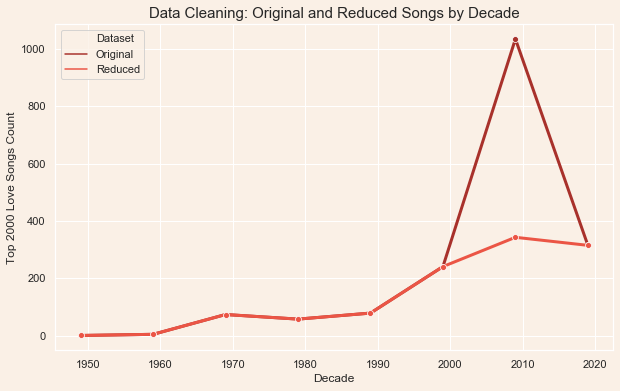

In [25]:
#Plot using seaborn
sns.set(rc={'axes.facecolor':'linen', 'figure.facecolor':'linen'})
fig_dims = (10, 6)
fig, ax = plt.subplots(figsize=fig_dims)
ax = sns.lineplot(x=decade_df['Decade'], y=decade_df['Top 2000 Love Songs Count'], hue=decade_df['Dataset'], \
                  palette='Reds_d', linewidth=3.0, marker='o', ax=ax)
ax.set_title("Data Cleaning: Original and Reduced Songs by Decade", fontsize=15)

plt.savefig("Results/Plots/songs_count_line.png")

# 2.1 Lyrics Cleanup
* Moludes needed: Natural Language Toolkit (NLTK) 
* NLTK is a Python package for natural language processing
* for info: https://www.nltk.org/data.html

In [26]:
# #Natural Language Toolkit (NLTK) is a Python package for natural language processing
# #Install nltk module (for info: https://www.nltk.org/data.html) *takes a while to download*
# !pip install nltk

In [27]:
#Dependencies 

# for nlkt (remove stop words)    ---> all available datasets/models:CORPORA: http://www.nltk.org/nltk_data/
from nltk.corpus import stopwords  #if stopwords corpus is not already downloaded: import nltk, nltk.download("stopwords") 

# for punctuation, import string library function  
import string 

#for stats
import scipy.stats as stats

In [28]:
#Open file with songs from top populated eras
song_with_lyrics_df=pd.read_csv("Results/csv/final_data.csv")

# #Drop weird column created for don't know what reason
song_list_df=song_with_lyrics_df.drop("Unnamed: 0", axis=1)

song_list_df.head()

,Rank,Song Name,Artist,Album,Lyrics,Year,bins
0,2,The Scientist,Coldplay,A Rush of Blood to the Head,"[Verse 1]\nCome up to meet you, tell you I'm s...",2002,2000s
1,3,Yellow,Coldplay,Parachutes,[Verse 1: Chris Martin]\nLook at the stars\nLo...,2000,2000s
2,4,Fix You,Coldplay,X&Y,[Verse 1: Chris Martin]\nWhen you try your bes...,2005,2000s
3,5,Chasing Cars,Snow Patrol,Eyes Open,[Verse 1]\nWe'll do it all\nEverything\nOn our...,2006,2000s
4,7,I'm Yours,Jason Mraz,I'm Yours,"[Verse 1]\nWell, you done done me, and you bet...",2008,2000s


In [29]:
#Check for duplicates in the list of songs
duplicates=song_list_df.duplicated(subset=["Song Name", "Artist"], keep=False)
song_list_df[duplicates]

,Rank,Song Name,Artist,Album,Lyrics,Year,bins


### Cleaning lyrics
* stop words (a, about, above, after, again, against, all....) (for info: https://www.geeksforgeeks.org/removing-stop-words-nltk-python/)
* punctuation characters (. ; : [] ? ...)
* words related to song structure (intro, chorus, verse)
* numbers
#### Create lists for:
* word count for each song
* unique words for each song
* unique words count for each song

In [30]:
#Clean lyrics and save a csv file for each song (it'd be easier to check lyrics if downstream errors occur )

#punctuation
punctuation=list(string.punctuation)

#stop words 
stop_words= set(stopwords.words('english')) 

#possible verse number (as strings)
numbers=[str(n) for n in range(100)]

#possible song structure terms and artist names
song_structure_words=["intro", "verse", "chorus", "bridge", "outro", "hook"] 

#list of total words, unique words (arrays) and unique_word_counts (series)
tot_words_list=[]            #list of total number of words per song
unique_words_list=[]         #list of unique words per song
unique_words_count_list=[]   #list of count of unique words per song


for index, row in song_list_df.iterrows():
    
    #Store song lyrics in a variable
    song_lyrics=song_list_df["Lyrics"][index]

    #Before splitting lyrics into words, remove punctation characters
    song_lyrics_clean= song_lyrics

    for x in punctuation:
        if not x == "'":
            song_lyrics_clean=song_lyrics_clean.replace(x,"")

    #Split string into list of words
    words_list= song_lyrics_clean.split() 

    #Make df of lowercase words (stop words are all lowercase)
    words_list_lower=[words_list[x].lower() for x in range(len(words_list))]

    #Remove stop words such as “the”, “a”, “an”, “in” 
    filtered_1=[k for k in words_list_lower if not k in stop_words]
    
    #remove possible verse number (as strings)
    filtered_2=[k for k in filtered_1 if not k in numbers] 

    #remove song structure words     
    filtered_lyrics_index=[k for k in filtered_2 if not k in song_structure_words] 
    
    #Create a df for lyrics analysis
    lyrics_index_df=pd.DataFrame()
 
    #Save song_lyrics_clean to a new dataframe
    lyrics_index_df[index]=filtered_lyrics_index
    
    #Append Number of words to word count list
    tot_words=len(lyrics_index_df[index])
    tot_words_list.append(tot_words)
    
    #Append Unique words to list
    unique_words=lyrics_index_df[index].unique()
    unique_words_list.append(unique_words)
    
    #Append Count of Unique words to list
    unique_words_count=lyrics_index_df[index].value_counts()
    unique_words_count_list.append(unique_words_count)    
    
    
    #Rename column and export to csv as lyrics_index.csv
    column_name= f'{song_list_df["Song Name"][index]}_{song_list_df["Artist"][index]}'
    lyrics_index_df=lyrics_index_df.rename(columns={index: column_name})
    lyrics_index_df.to_csv(f'Results/Lyrics/lyrics_{index}_df.csv')

#Display example of cleaned lyrics dataframe
lyrics_index_df

,You Wanted More_Tonic
0,love
1,tragic
2,love
3,bold
4,always
...,...
73,could
74,handle
75,life
76,can't


## 2.2 ANALYSIS: Word count per decade

In [31]:
#Create a new df with year, bin category and word count list
words_count_df=pd.DataFrame({
    "Song Name": song_list_df["Song Name"],
    "Artist": song_list_df["Artist"],
    "Words count": tot_words_list,
    "Year": song_list_df["Year"],
    "Bin": song_list_df["bins"]
})

words_count_df

,Song Name,Artist,Words count,Year,Bin
0,The Scientist,Coldplay,101,2002,2000s
1,Yellow,Coldplay,99,2000,2000s
2,Fix You,Coldplay,93,2005,2000s
3,Chasing Cars,Snow Patrol,83,2006,2000s
4,I'm Yours,Jason Mraz,227,2008,2000s
...,...,...,...,...,...
1106,Hard to Say I'm Sorry,Chicago,96,1983,80s
1107,Haunted,Taylor Swift,172,2010,2010s
1108,Breakthrough,Modest Mouse,118,1996,90s
1109,Saturday Night,Misfits,124,1999,90s


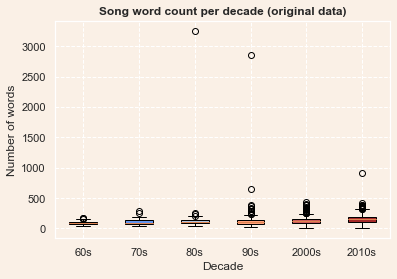

In [32]:
# #PLOT USING MATPLOTLIB

#Create separate subsets per bin
words_2010s=words_count_df.loc[words_count_df["Bin"] == "2010s"]["Words count"]
words_2000s=words_count_df.loc[words_count_df["Bin"] == "2000s"]["Words count"]
words_90s=words_count_df.loc[words_count_df["Bin"] == "90s"]["Words count"]
words_80s=words_count_df.loc[words_count_df["Bin"] == "80s"]["Words count"]
words_70s=words_count_df.loc[words_count_df["Bin"] == "70s"]["Words count"]
words_60s=words_count_df.loc[words_count_df["Bin"] == "60s"]["Words count"]

#plot
fig= plt.plot(figsize=(20,10))
labels=["60s", "70s", "80s", "90s", "2000s", "2010s"]
data=[words_60s, words_70s,words_80s, words_90s, words_2000s, words_2010s]

# rectangular box plot
bplot = plt.boxplot(data,patch_artist=True,  # fill with color,
                    labels=labels)  # will be used to label x-ticks

plt.title("Song word count per decade (original data)", fontsize=12, fontweight="bold")
plt.xlabel("Decade")
plt.ylabel("Number of words")
plt.grid(linestyle='--', linewidth=1)


# fill with colors
#Note: bplot is a dict, these are the keys: ['whiskers', 'caps', 'boxes', 'medians', 'fliers', 'means']
colors=["mediumblue", "cornflowerblue","lightsteelblue", "lightsalmon","indianred", "brown"]


for patch, color in zip(bplot["boxes"], colors):
        patch.set_facecolor(color)


plt.savefig("Results/Plots/word_count_boxplot_original_matplotlib.png")

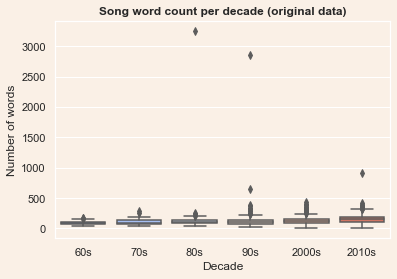

In [33]:
#PLOT USING SEABORN
order=["60s", "70s", "80s", "90s", "2000s", "2010s"]

# Use a color palette
fig=sns.boxplot( x=words_count_df["Bin"], y=words_count_df["Words count"], order=order,palette="coolwarm")
fig.set(xlabel='Decade', ylabel='Number of words')
fig.set_title("Song word count per decade (original data)", fontsize=12, fontweight="bold")
plt.savefig("Results/Plots/word_count_boxplot_original_seaborn.png")

### Check outliers

In [34]:
#Identify outliers from words_count_df with number of words >3000
outliers=words_count_df.loc[words_count_df["Words count"] > 2000]
outliers

,Song Name,Artist,Words count,Year,Bin
754,Everybody's Gotta Learn Sometimes,Beck,2851,1999,90s
1023,shhh.. Just listEn :),A Rocket to the Moon,3258,1988,80s


In [35]:
#Retrieve info for outliers in song_list_df
outliers_df=song_list_df.loc[(song_list_df.index == 754) | (song_list_df.index == 1023)]
outliers_df

,Rank,Song Name,Artist,Album,Lyrics,Year,bins
754,993,Everybody's Gotta Learn Sometimes,Beck,Cinematic Treatment,[Verse 1]\nSometimes you can fix something by ...,1999,90s
1023,774,shhh.. Just listEn :),A Rocket to the Moon,NaN,"FADE IN:\n\nEXT. WINTER RIVER, CONNECTICUT - D...",1988,80s


In [36]:
#A Rocket to the Moon - shhh.. Just listEn :)
outliers_df["Lyrics"][1023]

#Comment: A lot info in the lyrics, like " CAMERA EXPLORES, ATTIC - NEW ANGLE - DAY" CAMERA TILTS UP FROM THE WINDOW\
#-----> DROP!

'FADE IN:\n\nEXT. WINTER RIVER, CONNECTICUT - DAY\n\nA crisp and perfect New England town.  Almost too neat\nto be real.  No visible townspeople.  CAMERA EXPLORES\ntown.\n\n\nCAMERA FLIES\n\nover a rickety bridge -- PAST the Maitland Hardware and\nAppliance store -- PAST the church -- the Historical\nSociety -- UP over the graveyard on the hill and\nfinally --\n\nTo the Maitland house.  The perfect Victorian house\nsurveying the tiny village.  Suddenly --\n\n\nA GIANT DADDY LONGLEGS SPIDER\n\nmounts the crest of the hill beside the house, pauses to\nwave a spindly leg and then creeps menacingly on top of\nthe Maitland house.\n\nADAM (O.S..)\nWell, well, you\'re a big fella...!\n\nA hand -- as big as God\'s -- with a huge tweezer,\ngently reaches down out of the sky and lies, palm up,\nin the yard next to the house.  Daddy Longlegs climbs\ninto it.  The hand rises into the sky again.\n\n\nINT. ATTIC - NEW ANGLE - DAY\n\nReveals Winter River as a miniature town, while The\nDaddy Longlegs

In [37]:
#Beck - Everybody's Gotta Learn Sometimes
outliers_df["Lyrics"][754]

#Comment: the song does exist but the lyrics belong to another song (Genius problem) (The Devil Glitch by Chris Butler\
#also known as the longest song ever! Full version is 1h long. https://www.youtube.com/watch?v=10SnNfxjAI8)  -----> DROP!

'[Verse 1]\nSometimes you can fix something by just being a prick\nWinning by intimidation\n\n[Verse 2]\nSometimes you can fix something by just lifting your skirt\nIt\'s the ultimate distraction\n\n[Verse 3]\nI poke button\nI want action\nLet\'s hear some gears and see some smoke\nNo dilly-dally\nMove your heinie\nThis is the age of "go for broke"\n\n[Screw It, There Are 500 Verses, I Don\'t Have Time For This]\nSometimes you can fix something by just kissing some ass\nIf you don\'t mind humiliation\nSometimes you can fix something by just smoking a pipe\nAcademic contemplation\n\n\n\nSo pathetic\n\nNo mechanic\n\nNo steady eye, no magic touch\n\nNo screwdriver\n\nBall-peen hammer\n\nAnd Mr. Fix-it\'s gone to lunch\n\n\n\nNot personal?\n\nYeah it\'s personal\n\nWhat did I ever do to you?\n\nNo crap from\n\nContraptions\n\nJust do what I tell you to do\n\n\n\nSometimes you can fix something by just blaming your mom\n\nEverybody loves a victim\n\nSometimes you can fix something by just 

In [38]:
#Drop outliers
words_count_clean_df=words_count_df.drop([754, 1023])
words_count_clean_df

,Song Name,Artist,Words count,Year,Bin
0,The Scientist,Coldplay,101,2002,2000s
1,Yellow,Coldplay,99,2000,2000s
2,Fix You,Coldplay,93,2005,2000s
3,Chasing Cars,Snow Patrol,83,2006,2000s
4,I'm Yours,Jason Mraz,227,2008,2000s
...,...,...,...,...,...
1106,Hard to Say I'm Sorry,Chicago,96,1983,80s
1107,Haunted,Taylor Swift,172,2010,2010s
1108,Breakthrough,Modest Mouse,118,1996,90s
1109,Saturday Night,Misfits,124,1999,90s


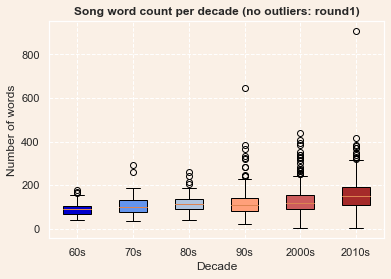

In [39]:
#PLOT USING MATPLOTLIB

#Create separate subsets per bin
words_2010s=words_count_clean_df.loc[words_count_clean_df["Bin"] == "2010s"]["Words count"]
words_2000s=words_count_clean_df.loc[words_count_clean_df["Bin"] == "2000s"]["Words count"]
words_90s=words_count_clean_df.loc[words_count_clean_df["Bin"] == "90s"]["Words count"]
words_80s=words_count_clean_df.loc[words_count_clean_df["Bin"] == "80s"]["Words count"]
words_70s=words_count_clean_df.loc[words_count_clean_df["Bin"] == "70s"]["Words count"]
words_60s=words_count_clean_df.loc[words_count_clean_df["Bin"] == "60s"]["Words count"]

#plot
fig= plt.plot(figsize=(20,10))
labels=["60s", "70s", "80s", "90s", "2000s", "2010s"]
data=[words_60s, words_70s,words_80s, words_90s, words_2000s, words_2010s]

# rectangular box plot
bplot = plt.boxplot(data,patch_artist=True,  # fill with color,
                    labels=labels)  # will be used to label x-ticks

plt.title("Song word count per decade (no outliers: round1)", fontsize=12, fontweight="bold")
plt.xlabel("Decade")
plt.ylabel("Number of words")
plt.grid(linestyle='--', linewidth=1)


# fill with colors
#Note: bplot is a dict, these are the keys: ['whiskers', 'caps', 'boxes', 'medians', 'fliers', 'means']
colors=["mediumblue", "cornflowerblue","lightsteelblue", "lightsalmon","indianred", "brown"]


for patch, color in zip(bplot["boxes"], colors):
        patch.set_facecolor(color)


plt.savefig("Results/Plots/word_count_boxplot_no_outliers_round1_matplotlib.png")

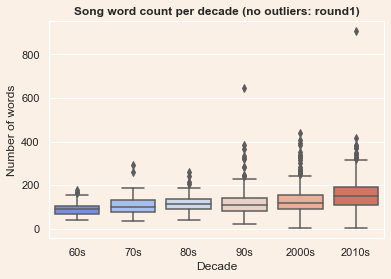

In [40]:
#PLOT USING SEABORN
order=["60s", "70s", "80s", "90s", "2000s", "2010s"]

# Use a color palette
fig=sns.boxplot( x=words_count_clean_df["Bin"], y=words_count_clean_df["Words count"], order=order,palette="coolwarm")
fig.set(xlabel='Decade', ylabel='Number of words')
fig.set_title("Song word count per decade (no outliers: round1)", fontsize=12, fontweight="bold")
plt.savefig("Results/Plots/word_count_boxplot_no_outliers_round1_seaborn.png")

### Check outliers: round 2
* there are two other strong outliers that we couldn't see in the first graph

In [41]:
#Identify outliers from words_count_df with number of words >600
outliers_2=words_count_clean_df.loc[words_count_clean_df["Words count"] > 600] 
outliers_2

,Song Name,Artist,Words count,Year,Bin
552,"Love Me Like You Do - From ""Fifty Shades of Grey""",Ellie Goulding,909,2015,2010s
991,Brown Skin Lady,Black Star,648,1998,90s


In [42]:
#Retrieve info for outliers in song_list_df
outliers_2_df=song_list_df.loc[(song_list_df.index == 552) | (song_list_df.index == 991)]
outliers_2_df

,Rank,Song Name,Artist,Album,Lyrics,Year,bins
552,523,"Love Me Like You Do - From ""Fifty Shades of Grey""",Ellie Goulding,"Love Me Like You Do (From ""Fifty Shades of Grey"")",Song of the Year\nKendrick Lamar - Alright\nTa...,2015,2010s
991,704,Brown Skin Lady,Black Star,Mos Def & Talib Kweli Are Black Star,[Sample: Chameleon Street]\nSmooth: You got th...,1998,90s


In [43]:
#Ellie Goulding - Love Me Like You Do - From "Fifty Shades of Grey"
outliers_2_df["Lyrics"][552]

#Comment: lyrics match from Genius is list of 2016 Grammys Nominees (https://genius.com/Grammys-2016-nominees-lyrics)
# ----> DROP

'Song of the Year\nKendrick Lamar - Alright\nTaylor Swift - Blank Space\nLittle Big Town - Girl Crush\nWiz Khalifa - See You Again ft. Charlie Puth\nEd Sheeran - Thinking Out Loud - WINNER\nRecord of the Year\nD\'Angelo & The Vanguard - Really Love\nMark Ronson - Uptown Funk ft. Bruno Mars - WINNER\nEd Sheeran - Thinking Out Loud\nTaylor Swift - Blank Space\nThe Weeknd - Can\'t Feel My Face\nAlbum of the Year\nAlabama Shakes - Sound & Color\nKendrick Lamar - To Pimp A Butterfly\nChris Stapleton - Traveller\nTaylor Swift - 1989 - WINNER\nThe Weeknd - Beauty Behind The Madness\nBest New Artist\nCourtney Barnett\nJames Bay\nSam Hunt\nTori Kelly\nMeghan Trainor - WINNER\nBest Rap Performance:\nJ. Cole - "Apparently"\nDrake - "Back to Back"\nFetty Wap - "Trap Queen"\nKendrick Lamar - "Alright" - WINNER\nNicki Minaj - "Truffle Butter" ft. Drake & Lil\' Wayne\nKanye West - "All Day" ft. Theophilus London\nBest Rap/Sung Collaboration:\nBig Sean - "One Man Can Change the World" ft. Kanye West &

In [44]:
#Black Star - Brown Skin Lady"
outliers_2_df["Lyrics"][991]

#Comment: Song really has long lyrics, both members of the band (Talib Kweli and Mos Def) sing at the same time 
#(https://genius.com/Black-star-brown-skin-lady-lyrics)  ----> Could keep but it's indeed an outlier

'[Sample: Chameleon Street]\nSmooth: You got that good hair too\nWilliam Douglas Street: You like what?\nSmooth: I like girls with that light complexion on them\nStreet: You\'re a moron\nSmooth: I can\'t help it\nStreet: What? Being a moron\nSmooth: Yeah that too\nStreet: You\'re the first one out there with a dashiki talking that crap\nSmooth: I\'m a victim -\nStreet: "Good hair." Nigga you so brainwashed\nSmooth: I\'m a victim brother\nStreet: You\'re a \'victim\'\nSmooth: I\'m a victim of 400 years of conditioning\nStreet: Shut up\nSmooth: The Man has programmed my conditioning\nStreet: Mhm\nSmooth: Even my conditioning has been conditioned\n\n[Intro: Talib Kweli & Mos Def]\nBut most of yall brothers\nCame from your mothers\nLooking all sweet (Black Star keep shining)\nAnd be like yo, let me ask you somethin\nI wanna know, I wanna know who you are\n\n[Chorus: Mos Def & Talib Kweli]\nBrown skin lady, hey hey\nYes\nWhere you goin\'\nThis goes to the brown skin ladies yo\nBrown skin la

In [45]:
#Drop outliers and save df
words_count_clean_2_df=words_count_clean_df.drop([552, 991])

words_count_clean_2_df.to_csv("Results/csv/song_list_no_outliers.csv")
words_count_clean_2_df

,Song Name,Artist,Words count,Year,Bin
0,The Scientist,Coldplay,101,2002,2000s
1,Yellow,Coldplay,99,2000,2000s
2,Fix You,Coldplay,93,2005,2000s
3,Chasing Cars,Snow Patrol,83,2006,2000s
4,I'm Yours,Jason Mraz,227,2008,2000s
...,...,...,...,...,...
1106,Hard to Say I'm Sorry,Chicago,96,1983,80s
1107,Haunted,Taylor Swift,172,2010,2010s
1108,Breakthrough,Modest Mouse,118,1996,90s
1109,Saturday Night,Misfits,124,1999,90s


In [46]:
#Statistical analysis OneWay ANOVA

#create separate subsets per bin
words_2010s=words_count_clean_2_df.loc[words_count_clean_2_df["Bin"] == "2010s"]["Words count"]
words_2000s=words_count_clean_2_df.loc[words_count_clean_2_df["Bin"] == "2000s"]["Words count"]
words_90s=words_count_clean_2_df.loc[words_count_clean_2_df["Bin"] == "90s"]["Words count"]
words_80s=words_count_clean_2_df.loc[words_count_clean_2_df["Bin"] == "80s"]["Words count"]
words_70s=words_count_clean_2_df.loc[words_count_clean_2_df["Bin"] == "70s"]["Words count"]
words_60s=words_count_clean_2_df.loc[words_count_clean_2_df["Bin"] == "60s"]["Words count"]

#run OneWay ANOVA
(statistic, pvalue)=stats.f_oneway(words_2010s, words_2000s, words_90s, words_80s, words_70s, words_60s)
print(f'The OneWay ANOVA pvalue is: {pvalue}')

The OneWay ANOVA pvalue is: 8.395836195399574e-22


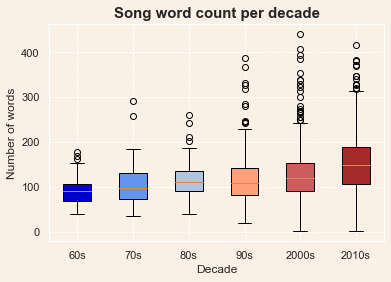

In [47]:
#PLOT USING MATPLOTLIB
fig= plt.plot(figsize=(20,10))
labels=["60s", "70s", "80s", "90s", "2000s", "2010s"]
data=[words_60s, words_70s,words_80s, words_90s, words_2000s, words_2010s]

# rectangular box plot
bplot = plt.boxplot(data,patch_artist=True,  # fill with color,
                    labels=labels)  # will be used to label x-ticks

plt.title("Song word count per decade", fontsize=15, fontweight="bold")
plt.xlabel("Decade", fontsize=12)
plt.ylabel("Number of words", fontsize=12)
plt.grid(linestyle='--', linewidth=1)

# fill with colors
#Note: bplot is a dict, these are the keys: ['whiskers', 'caps', 'boxes', 'medians', 'fliers', 'means']
colors=["mediumblue", "cornflowerblue","lightsteelblue", "lightsalmon","indianred", "brown"]


for patch, color in zip(bplot["boxes"], colors):
        patch.set_facecolor(color)

plt.savefig("Results/Plots/word_count_boxplot_final_matplotlib.png")

The OneWay ANOVA pvalue is: 8.395836195399574e-22


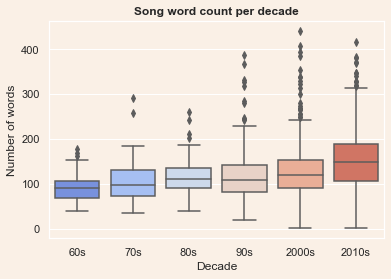

In [48]:
#PLOT USING SEABORN

order=["60s", "70s", "80s", "90s", "2000s", "2010s"]

# Use a color palette
fig=sns.boxplot( x=words_count_clean_2_df["Bin"], y=words_count_clean_2_df["Words count"], order=order,palette="coolwarm")
fig.set(xlabel='Decade', ylabel='Number of words')
fig.set_title("Song word count per decade", fontsize=12, fontweight="bold")
plt.savefig("Results/Plots/word_count_boxplot_final_seaborn.png")
print(f'The OneWay ANOVA pvalue is: {pvalue}')

### Question: is there a correlation between number of words and number of songs in a decade?

The correlation coefficient is: 0.7951070778159567


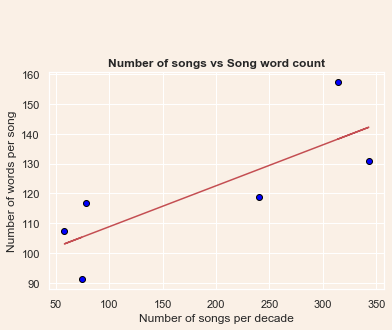

In [49]:
#Scatter Plot
x_values=[len(words_60s), len(words_70s),len(words_80s), len(words_90s), len(words_2000s), len(words_2010s)]
y_values=[words_60s.mean(), words_70s.mean(),words_80s.mean(), words_90s.mean(), words_2000s.mean(), words_2010s.mean()]

plt.scatter(x_values, y_values, marker= "o", c="blue", edgecolors= "black")
plt.title("Number of songs vs Song word count", fontsize=12, fontweight="bold")
plt.xlabel("Number of songs per decade")
plt.ylabel("Number of words per song")



#linear regression
(slope, intercept, rvalue, pvalue, stdev)= stats.linregress(x_values, y_values)
print(f'The correlation coefficient is: {rvalue}')


x_series=pd.Series(x_values)
regress_values= x_series*slope + intercept
line_eq= f'y={str(round(slope, 2))}x + {str(round(intercept,2))}'

plt.plot(x_values, regress_values, "r-")
plt.annotate(line_eq, (100,180), fontsize=12, color= "red")

plt.savefig("Results/Plots/correlation_songwords_songnumber")

## ANALYSIS: Common words

In [50]:
#Dependencies
import collections

In [51]:
#Retrieve list of unique words for each song and replace the lyrics column with it
unique_words_list
song_list_df['Clean Lyrics'] = unique_words_list

unique_words_df = song_list_df.drop("Lyrics", axis=1)

unique_words_df.head()

,Rank,Song Name,Artist,Album,Year,bins,Clean Lyrics
0,2,The Scientist,Coldplay,A Rush of Blood to the Head,2002,2000s,"[come, meet, tell, i'm, sorry, know, lovely, f..."
1,3,Yellow,Coldplay,Parachutes,2000,2000s,"[chris, martin, look, stars, shine, everything..."
2,4,Fix You,Coldplay,X&Y,2005,2000s,"[chris, martin, try, best, succeed, get, want,..."
3,5,Chasing Cars,Snow Patrol,Eyes Open,2006,2000s,"[we'll, everything, need, anything, anyone, la..."
4,7,I'm Yours,Jason Mraz,I'm Yours,2008,2000s,"[well, done, bet, felt, tried, chill, hot, mel..."


In [52]:
# sort dataframe with lyrics into songs from 2010s
df_10 = unique_words_df.loc[unique_words_df["bins"] == "2010s"]

# export csv of lyrics from the 2010s
df_10_lyrics = df_10['Clean Lyrics']
df_10_lyrics.to_csv("Results/csv/2010s_lyrics.csv")

In [53]:
# sort dataframe with lyrics into songs from 2000s
df_00 = unique_words_df.loc[unique_words_df["bins"] == "2000s"]

# export csv of lyrics from the 2000s
df_00_lyrics = df_00['Clean Lyrics']
df_00_lyrics.to_csv("Results/csv/2000s_lyrics.csv")

In [54]:
# sort dataframe with lyrics into songs from 90s
df_90 = unique_words_df.loc[unique_words_df["bins"] == "90s"]

# export csv of lyrics from the 60s
df_90_lyrics = df_90['Clean Lyrics']
df_90_lyrics.to_csv("Results/csv/90s_lyrics.csv")

In [55]:
# sort dataframe with lyrics into songs from 80s
df_80 = unique_words_df.loc[unique_words_df["bins"] == "80s"]

# export csv of lyrics from the 80s
df_80_lyrics = df_80['Clean Lyrics']
df_80_lyrics.to_csv("Results/csv/80s_lyrics.csv")

In [56]:
# sort dataframe with lyrics into songs from 70s
df_70 = unique_words_df.loc[unique_words_df["bins"] == "70s"]

# export csv of lyrics from the 70s
df_70_lyrics = df_70['Clean Lyrics']
df_70_lyrics.to_csv("Results/csv/70s_lyrics.csv")

In [57]:
# sort dataframe with lyrics into songs from 60s
df_60 = unique_words_df.loc[unique_words_df["bins"] == "60s"]

# export csv of lyrics from the 60s
df_60_lyrics = df_60['Clean Lyrics']
df_60_lyrics.to_csv("Results/csv/60s_lyrics.csv")

df_60.head()

,Rank,Song Name,Artist,Album,Year,bins,Clean Lyrics
356,42,All You Need Is Love,The Beatles,Magical Mystery Tour,1967,60s,"[love, there's, nothing, can't, done, sing, su..."
359,47,Something,The Beatles,Abbey Road,1969,60s,"[something, way, moves, attracts, like, lover,..."
367,78,Love Me Do,The Beatles,Please Please Me,1962,60s,"[paul, mccartney, john, lennon, love, know, i'..."
368,79,Wouldn't It Be Nice,The Beach Boys,Stack-O-Tracks,1966,60s,"[nice, older, wait, long, live, together, kind..."
369,80,I Want to Hold Your Hand,The Beatles,1,1963,60s,"[paul, mccartney, john, lennon, oh, yeah, i'll..."


#### 60s

'love' :  56
'know' :  37
'see' :  27
'oh' :  26
'like' :  25
'say' :  24
'want' :  24
'day' :  21
'never' :  21
""can't"" :  20
'go' :  20
'heart' :  20
'time' :  19
'got' :  19
'one' :  17
'way' :  17
'long' :  17
'need' :  16
'could' :  16
'make' :  15


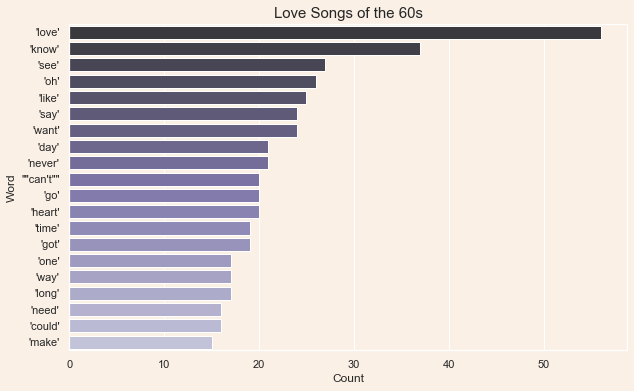

In [58]:
# read csv
file = open('Results/csv/60s_lyrics.csv', encoding="utf8")
a= file.read()

# Create a dictionary to store word counts
wordcount = {}

# Split by punctuation to remove duplicates
for word in a.split():

    if word not in wordcount:
            wordcount[word] = 1
    
    else:
            wordcount[word] += 1
            
# Print most common word
n_print = 20

word_counter = collections.Counter(wordcount)

for word, count in word_counter.most_common(n_print):
    print(word, ": ", count)


lst = word_counter.most_common(n_print)

# Create a data frame of the most common words 
words_df = pd.DataFrame(lst, columns = ['Word', 'Count'])

# plot an ugly horizontal bar chart using matplotlib and pandas:
    # words_df.plot.barh(x='Word', y='Count')
    # plt.gca().invert_yaxis()

# plot a much prettier horizontal bar chart using seaborn
sns.set(rc={'axes.facecolor':'linen', 'figure.facecolor':'linen'})
fig_dims = (10, 6)
fig, ax = plt.subplots(figsize=fig_dims)
ax = sns.barplot(x=words_df['Count'], y=words_df['Word'], palette='Purples_d', ax=ax)
ax.set_title("Love Songs of the 60s", fontsize=15)
plt.savefig("Results/Plots/60s_common_words.png")

#### 70s

'love' :  40
'know' :  27
'like' :  22
'time' :  20
'oh' :  19
'see' :  19
'life' :  18
'way' :  17
'heart' :  16
'eyes' :  15
'feel' :  15
""that's"" :  15
'never' :  15
'could' :  14
'go' :  14
'come' :  14
'make' :  14
'got' :  13
'want' :  13
""can't"" :  12


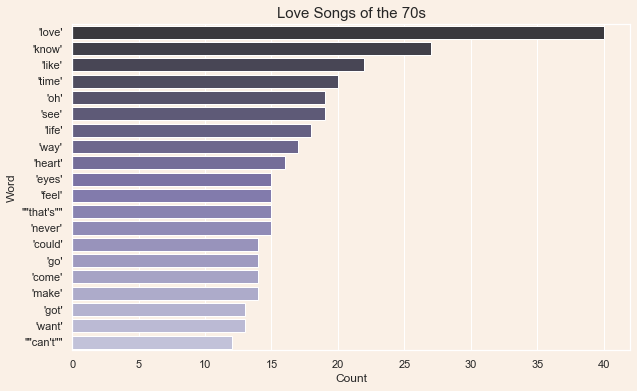

In [59]:
# read csv
file = open('Results/csv/70s_lyrics.csv', encoding="utf8")
a= file.read()

# Create a dictionary to store word counts
wordcount = {}

# Split by punctuation to remove duplicates
for word in a.split():

    if word not in wordcount:
            wordcount[word] = 1
    
    else:
            wordcount[word] += 1
            
# Print most common word
n_print = 20

word_counter = collections.Counter(wordcount)

for word, count in word_counter.most_common(n_print):
    print(word, ": ", count)


lst = word_counter.most_common(n_print)

# Create a data frame of the most common words 
words_df = pd.DataFrame(lst, columns = ['Word', 'Count'])

# plot an ugly horizontal bar chart using matplotlib and pandas:
    # words_df.plot.barh(x='Word', y='Count')
    # plt.gca().invert_yaxis()

# plot a much prettier horizontal bar chart using seaborn
sns.set(rc={'axes.facecolor':'linen', 'figure.facecolor':'linen'})
fig_dims = (10, 6)
fig, ax = plt.subplots(figsize=fig_dims)
ax = sns.barplot(x=words_df['Count'], y=words_df['Word'], palette='Purples_d', ax=ax)
ax.set_title("Love Songs of the 70s", fontsize=15)
plt.savefig("Results/Plots/70s_common_words.png")

#### 80s

'love' :  47
'time' :  39
'know' :  36
'see' :  32
'away' :  30
""can't"" :  30
'go' :  30
'make' :  29
'feel' :  29
'heart' :  28
'never' :  27
'say' :  26
'want' :  25
'oh' :  23
'let' :  23
'like' :  22
'got' :  21
'come' :  21
'take' :  21
'long' :  20


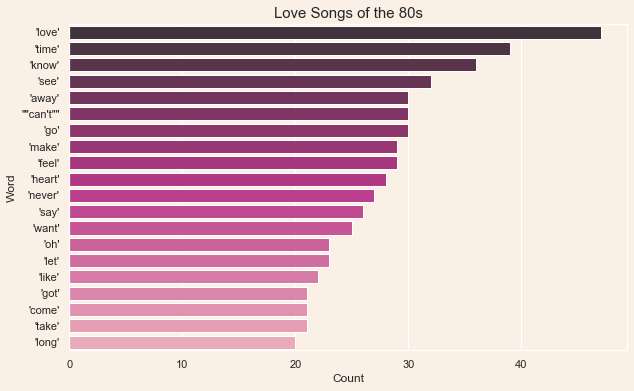

In [60]:
# read csv
file = open('Results/csv/80s_lyrics.csv', encoding="utf8")
a= file.read()

# Create a dictionary to store word counts
wordcount = {}

# Split by punctuation to remove duplicates
for word in a.split():

    if word not in wordcount:
            wordcount[word] = 1
    
    else:
            wordcount[word] += 1
            
# Print most common word
n_print = 20

word_counter = collections.Counter(wordcount)

for word, count in word_counter.most_common(n_print):
    print(word, ": ", count)


lst = word_counter.most_common(n_print)

# Create a data frame of the most common words 
words_df = pd.DataFrame(lst, columns = ['Word', 'Count'])

# plot an ugly horizontal bar chart using matplotlib and pandas:
    # words_df.plot.barh(x='Word', y='Count')
    # plt.gca().invert_yaxis()

# plot a much prettier horizontal bar chart using seaborn
sns.set(rc={'axes.facecolor':'linen', 'figure.facecolor':'linen'})
fig_dims = (10, 6)
fig, ax = plt.subplots(figsize=fig_dims)
ax = sns.barplot(x=words_df['Count'], y=words_df['Word'], palette='RdPu_d', ax=ax)
ax.set_title("Love Songs of the 80s", fontsize=15)
plt.savefig("Results/Plots/80s_common_words.png")

#### 90s

'love' :  147
'know' :  127
'like' :  112
'never' :  91
'see' :  89
'one' :  87
'feel' :  81
'go' :  76
""can't"" :  75
'time' :  75
'could' :  73
'oh' :  72
'make' :  71
'say' :  69
'way' :  68
'want' :  66
'heart' :  66
'away' :  66
'eyes' :  63
'get' :  62


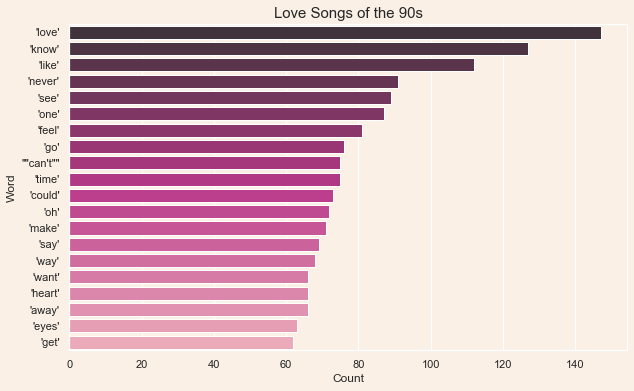

In [61]:
# read csv
file = open('Results/csv/90s_lyrics.csv', encoding="utf8")
a= file.read()

# Create a dictionary to store word counts
wordcount = {}

# Split by punctuation to remove duplicates
for word in a.split():

    if word not in wordcount:
            wordcount[word] = 1
    
    else:
            wordcount[word] += 1
            
# Print most common word
n_print = 20

word_counter = collections.Counter(wordcount)

for word, count in word_counter.most_common(n_print):
    print(word, ": ", count)


lst = word_counter.most_common(n_print)

# Create a data frame of the most common words 
words_df = pd.DataFrame(lst, columns = ['Word', 'Count'])

# plot an ugly horizontal bar chart using matplotlib and pandas:
    # words_df.plot.barh(x='Word', y='Count')
    # plt.gca().invert_yaxis()

# plot a much prettier horizontal bar chart using seaborn
sns.set(rc={'axes.facecolor':'linen', 'figure.facecolor':'linen'})
fig_dims = (10, 6)
fig, ax = plt.subplots(figsize=fig_dims)
ax = sns.barplot(x=words_df['Count'], y=words_df['Word'], palette='RdPu_d', ax=ax)
ax.set_title("Love Songs of the 90s", fontsize=15)

plt.savefig("Results/Plots/90s_common_words.png")

#### 2000s

'know' :  183
'love' :  174
'like' :  152
'see' :  127
'time' :  121
'say' :  118
'one' :  116
'never' :  113
'make' :  111
'go' :  106
'take' :  106
'oh' :  102
'got' :  102
'get' :  90
""can't"" :  89
'heart' :  88
'back' :  85
'need' :  83
'come' :  83
'let' :  83


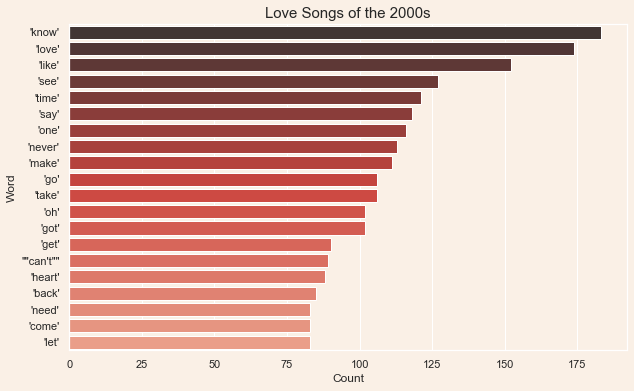

In [62]:
# read csv
file = open('Results/csv/2000s_lyrics.csv', encoding="utf8")
a= file.read()

# Create a dictionary to store word counts
wordcount = {}

# Split by punctuation to remove duplicates
for word in a.split():

    if word not in wordcount:
            wordcount[word] = 1
    
    else:
            wordcount[word] += 1
            
# Print most common word
n_print = 20

word_counter = collections.Counter(wordcount)

for word, count in word_counter.most_common(n_print):
    print(word, ": ", count)


lst = word_counter.most_common(n_print)

# Create a data frame of the most common words 
words_df = pd.DataFrame(lst, columns = ['Word', 'Count'])

# plot an ugly horizontal bar chart using matplotlib and pandas
# words_df.plot.barh(x='Word', y='Count')
# plt.gca().invert_yaxis()

# plot a much prettier horizontal bar chart using seaborn

sns.set(rc={'axes.facecolor':'linen', 'figure.facecolor':'linen'})
fig_dims = (10, 6)
fig, ax = plt.subplots(figsize=fig_dims)

ax = sns.barplot(x=words_df['Count'], y=words_df['Word'], palette='Reds_d', ax=ax)
ax.set_title("Love Songs of the 2000s", fontsize=15)

plt.savefig("Results/Plots/2000s_common_words.png")

#### 2010s

'like' :  180
'love' :  176
'know' :  174
'time' :  125
'got' :  121
'oh' :  120
'never' :  118
'see' :  114
'go' :  106
""can't"" :  103
'say' :  101
'one' :  99
'let' :  98
'get' :  96
'feel' :  93
'take' :  93
'make' :  88
'want' :  88
'yeah' :  87
'baby' :  86


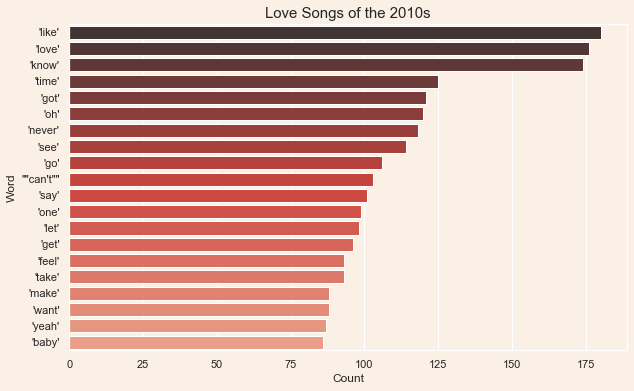

In [63]:
# read csv
file = open('Results/csv/2010s_lyrics.csv', encoding="utf8")
a= file.read()

# Create a dictionary to store word counts
wordcount = {}

# Split by punctuation to remove duplicates
for word in a.split():

    if word not in wordcount:
            wordcount[word] = 1
    
    else:
            wordcount[word] += 1
            
# Print most common word
n_print = 20

word_counter = collections.Counter(wordcount)

for word, count in word_counter.most_common(n_print):
    print(word, ": ", count)


lst = word_counter.most_common(n_print)

# Create a data frame of the most common words 
words_df = pd.DataFrame(lst, columns = ['Word', 'Count'])

# plot an ugly horizontal bar chart using matplotlib and pandas:
    # words_df.plot.barh(x='Word', y='Count')
    # plt.gca().invert_yaxis()

# plot a much prettier horizontal bar chart using seaborn
sns.set(rc={'axes.facecolor':'linen', 'figure.facecolor':'linen'})
fig_dims = (10, 6)
fig, ax = plt.subplots(figsize=fig_dims)
ax = sns.barplot(x=words_df['Count'], y=words_df['Word'], palette='Reds_d', ax=ax)
ax.set_title("Love Songs of the 2010s", fontsize=15)

plt.savefig("Results/Plots/2010s_common_words.png")